# R peak detection in ECG signal using wavelet transform
In this notebook we are going to detect the r peaks in an filtered ecg signal using the stationary wavelet transform.

In [1]:
import scipy.io as sio
import pywt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Helper functions

In [2]:
def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()

def find(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

## Load signal data

In [3]:
mat = sio.loadmat("data/qrs_detect.mat")
signal = mat['signal']
samplerate = mat['samplerate'][0][0]


L = next_power_of_2(signal.shape[1])
signalECG = np.zeros((L))
signalECG[0:signal.shape[1]] = signal[:]
t = np.arange(0,L)/samplerate

## Stationary Wavelet Transform
https://pywavelets.readthedocs.io/en/latest/ref/swt-stationary-wavelet-transform.html

In [4]:
# Stationary wavelet transform
swd = pywt.swt(signalECG,'db1', 10)
wavelet_level = int(np.floor(np.log2(samplerate/2/30)))
detailECG = swd[wavelet_level][1]

# Find wavelet maximums
detailAbs = np.abs(detailECG)
detailThres = detailAbs

## Find peaks ind detail coefficients

In [5]:
# Filter wavelet coefficients with threshold (factor*average)
factor = 3

detailThres[detailThres < np.mean(detailAbs)*factor] = 0
detailSlope = np.gradient(detailThres)

# Find maximums of the wavelet coefficients
waveMax = np.zeros((L))
for k in range(1,L-2):
    if (detailSlope[k-1] > 0) and (detailSlope[k+1] < 0):
        waveMax[k] = 1
        
# Project maximums to ECG singal (--> R-peaks)
rPeak = np.zeros((L))
window = int(np.round(0.1*samplerate))

for k in range(L-window-1):
    if waveMax[k] == 1:
        I = np.argmax(np.abs(signalECG[k:k+window]))
        rPeak[k+I] = 1
        
# Eliminate multiple points per peak
QTinterval = 0.35 #QT intervak approx. 350 ms
interval = int(np.round(samplerate * QTinterval))
for k in range(interval, L-interval-1): #Eliminate all but the maximum in the interval
    if rPeak[k] == 1:
        index = np.argmax(np.abs(rPeak[k-interval:k+interval]))
        rPeak[k-interval:k-interval+index-1] = 0
        rPeak[k-interval+index+1:k+interval] = 0

## Plot results

[]

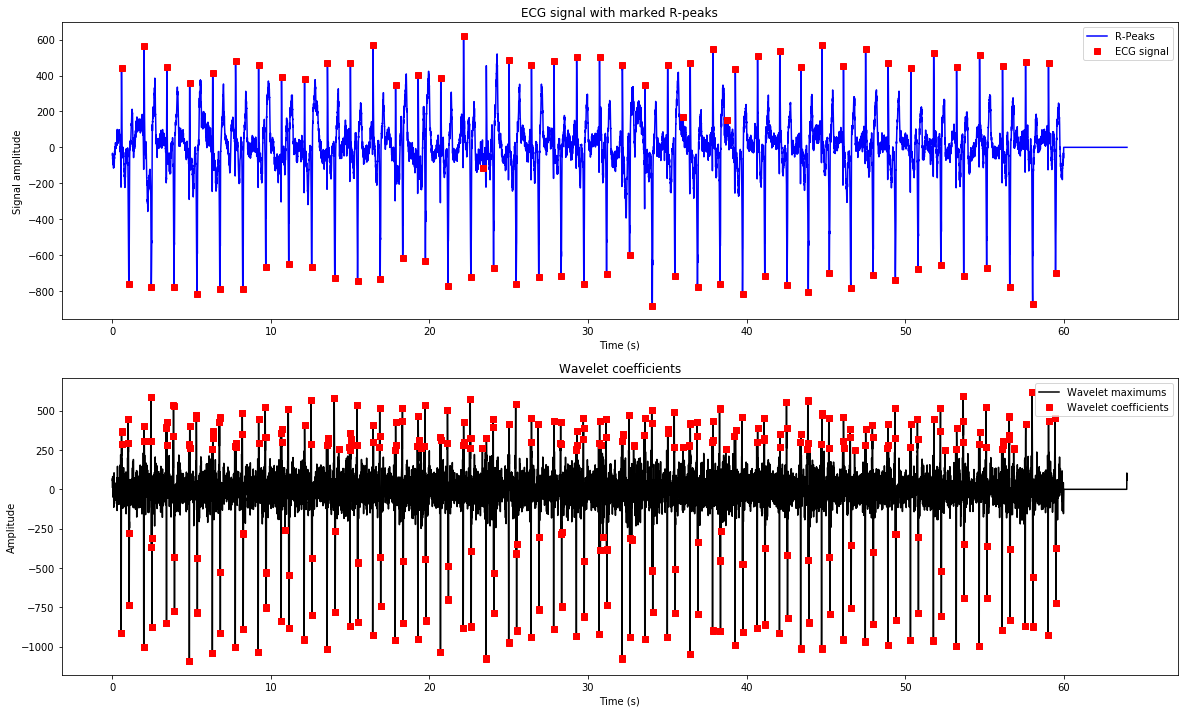

In [6]:
wavePoints = find(waveMax, lambda x: x > 0) # indices of the wavelet maximums
rPoints = find(rPeak, lambda x: x > 0) # indices of the r-peak

plt.figure(figsize=(20, 12))

plt.subplot(2,1,1)
plt.plot(t,signalECG,'b');
plt.plot(t[rPoints],signalECG[rPoints],'rs')
plt.xlabel('Time (s)')
plt.ylabel('Signal amplitude')
plt.title('ECG signal with marked R-peaks')
plt.legend(['R-Peaks','ECG signal'])

plt.subplot(2,1,2)
plt.plot(t,detailECG,'black')
plt.plot(t[wavePoints],detailECG[wavePoints],'rs')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Wavelet coefficients')
plt.legend(['Wavelet maximums','Wavelet coefficients'])

plt.plot()